# Lab 1: Coulomb's Law

Here is the first cell.  We are going to start with a calibration of the torsion pendulum.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Calibration of the Torsion Pendulum


In [2]:
# Create a Pandas DataFrame with data for calibration of Torsion pendulum

# The data elements are [mass in mg, error in mass in mg, angle in degrees, error in angle in degrees]
calibration_data = [[0, 0.0, 25.5, 0.5], [20, 0.0, 160,0.5], [40, 0.0, 291,0.5], 
                    [50, 0.0, 353.5,0.5], [70, 0.0, 490,0.5], [90, 0.0, 630,0.5]]

# The values in this next line are for the WebWork exercise.
#calibration_data = [[152.9, 0.0, 9.3, 0.0], [448.5, 0.0, 19.3, 0.0], 
#                    [550.5, 0.0, 25.1, 0.0], [560.7, 0.0, 29.8, 0.0], 
#                    [825.7, 0.0, 39.1, 0.0]]

# create dataframe
df = pd.DataFrame(calibration_data, columns = ['Mass_mg', 'dMass_mg', 'Theta_Raw', 'dTheta_Raw'])

print('Raw Data - Calibration')
df


Raw Data - Calibration


,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw
0,0,0.0,25.5,0.5
1,20,0.0,160.0,0.5
2,40,0.0,291.0,0.5
3,50,0.0,353.5,0.5
4,70,0.0,490.0,0.5
5,90,0.0,630.0,0.5


In [3]:
# What is the uncertainty in the mass?  We are not really told in the video.  But, let's
# make an educated guess ... it is probably going to be some absolute finite number, plus
# some percentage error.

df['dMass_mg'] = 0.1 + df['Mass_mg']*0.01

# Calcualate the actual value of theta by subtracting off the angle for Mass=0.  Also, 
# calculate the error in the actual angle using dTheta = dTheta_Raw[i] + dtheta_Raw[0]

offset = df['Theta_Raw'][0]
doffset = df['dTheta_Raw'][0]

# For WebWork
#offset = 0
#doffset = 0

df['Theta'] = df['Theta_Raw'] - offset
df['dTheta'] = df['dTheta_Raw'] + doffset

# Calculate the mass in kg, and the error in the mass in kg
df['Mass'] = df['Mass_mg']*0.000001
df['dMass'] = df['dMass_mg']*0.000001

# Calculate the gravitational Force (and Error) in Newtons
g = 9.81
df['Force'] = df['Mass']*g
df['dForce'] = df['dMass']*g

print(df.to_string(index=False))

 Mass_mg  dMass_mg  Theta_Raw  dTheta_Raw  Theta  dTheta     Mass         dMass     Force        dForce
       0       0.1       25.5         0.5    0.0     1.0  0.00000  1.000000e-07  0.000000  9.810000e-07
      20       0.3      160.0         0.5  134.5     1.0  0.00002  3.000000e-07  0.000196  2.943000e-06
      40       0.5      291.0         0.5  265.5     1.0  0.00004  5.000000e-07  0.000392  4.905000e-06
      50       0.6      353.5         0.5  328.0     1.0  0.00005  6.000000e-07  0.000490  5.886000e-06
      70       0.8      490.0         0.5  464.5     1.0  0.00007  8.000000e-07  0.000687  7.848000e-06
      90       1.0      630.0         0.5  604.5     1.0  0.00009  1.000000e-06  0.000883  9.810000e-06


# Fitting Stuff

You may have already seen examples of both linear and non-linear regression fits to data.  In most (maybe all?) experiments though, we often have uncertainties associated with each data point.  We should understand more about how this affects the fitting procedure.

The linear/non-linear regression examples that we have studied thus far use a method called "Ordinary Least Squares".  The basic theory behind this is:

$\chi^2 = \sum_i^N (y_i - y_{fit}(x_i))^2$

where $y_{fit} = f(a,b,c,...)$ is the fitting function.  The idea is that we must solve the set of equations defined by:

$\frac{\partial \chi^2}{\partial a} = 0, \frac{\partial \chi^2}{\partial b} = 0, \frac{\partial \chi^2}{\partial c} = 0, ...$

In the case of polynomial fitting functions (of any order), the values of the polynomial coefficients are uniquely defined.  That is, there is a single global minimum in the $\chi^2$ function.  For other non-linear fitting functions, there may be local minima in the $\chi^2$ function, and this requires that we provide initial starting values for the parameters of the fitting function that are close to the global minimum.

When we have uncertainties for each of the $N$ data points, the definition of $\chi^2$ becomes:

$\chi^2 = \sum_i^N \left (\frac{y_i - y_{fit}(x_i)}{\sigma_i}\right)^2$

Now, for this calibration procedure, we have ZERO uncertainty in the y-variable (Mass), and we have some non-zero uncertainty in the x-variable (Angle).  As it turns out, the Ordinary Least Squares procedure can ONLY take into account uncertainties in the y-variable!!!!  This is a actually a significant limitation of this procedure, and we actually should use a more advanced methodology.

The method of choice here is called Orthogonal Distance Regression.  The idea is that we want to minimize the orthogonal distance between the line of best fit and the data points.  It is actually a fairly complicated procedure, and we are
going to use some Python code that I have written to do this that uses some Python libraries written expressly for this
purpose.

# The Fitting Code

The following cell is a very important one!  We will be using this fitting procedure in basically every experiment this semester!!!!

The idea is this:  The first few lines are where we define the data to be fitted.  We need an array of x-values (xi), an array of y-values (yi). We also
include definitions of arrays for the uncertainties in x (sigmaxi) and y (sigmayi).

The lines after that carry out a fairly sophisticated fitting procedure that includes calculation of upper and lower "bands" of the fit corresponding to the error limits on the fit parameters.  These lines give a nice visual
interpretation of how good the fit is, and whether it captures the variation in the
data.

This code also prints out the final result for the Y = (m +/- dm)X + ( b +/- db) fit.  

*NOTE*:  You might have to change the number of decimal places that are printed out for the final result!!!

Beta: [ 1.47530649e-06 -1.35261052e-07]
Beta Std Error: [7.75304054e-09 1.31187721e-06]
Beta Covariance: [[ 9.65001736e-17 -8.62439800e-15]
 [-8.62439800e-15  2.76293302e-12]]
Residual Variance: 0.6228966783454686
Inverse Condition #: 0.005027569050915572
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.000001475 +/- 0.000000008) X + (-0.000000135 +/- 0.000001312)


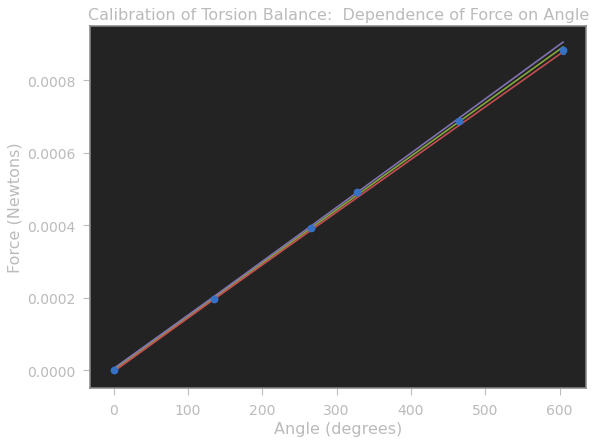

In [4]:
xi = df['Theta']
yi = df['Force']
sigmaxi = df['dTheta']
sigmayi = df['dForce']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[1., 2.]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Angle (degrees)')
plt.ylabel('Force (Newtons)')
plt.title('Calibration of Torsion Balance:  Dependence of Force on Angle')
plt.show()

## Analysis of Calibration Result

First of all, we see that this is a very good fit.  The upper and lower error band lines
are barely distinguishable from one another.  This tells us that we are able to determine the Force for a given angle quite accurately!  Cool!

Second, we see that the result for the y-intercept (b) is consistent with zero $(0.135 \pm 1.312) \times 10^{-6}$ Newtons.  This is consistent with our expectations.  Since it is consistent with
zero, we can just ignore this going forward and assume it is identically zero.

Third, we see that the calibration constant that we were trying to determine is
$(1.475 \pm 0.008) \times 10^{-6}$ Newtons/degree.  As we said, this is quite well-determined ... the percentage error is $(0.008/1.475)*100\% = 0.54 \%$.

In [5]:
#
# Remember the results of the calibration part of the experiment ... we will use this later, to convert angles into Force values!
#
calibration_factor = popt[0]
dcalibration_factor = perr[0]

# Part I:  Investigation of the Dependence of the Force on Distance

In [6]:
# Create a Pandas DataFrame with data for part 1 of the experiment:  understanding the relation of Force to distance, at constant
# charge

# The data elements are [distance in cm, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors
data1 = [[20,15, 0.5], [20,16.5,0.5], [14,45,0.5], [14,40,0.5], [10,65,0.5], [10,72,0.5], [9,80,0.5], 
         [9,80,0.5], [8,105,0.5], [8,103,0.5], [7,141,0.5], [7,140,0.5], [6,181,0.5], [6,178,0.5]]
# create dataframe
df2 = pd.DataFrame(data1, columns = ['R_cm', 'Theta','dTheta'])

print(df2.to_string(index=False))

 R_cm  Theta  dTheta
   20   15.0     0.5
   20   16.5     0.5
   14   45.0     0.5
   14   40.0     0.5
   10   65.0     0.5
   10   72.0     0.5
    9   80.0     0.5
    9   80.0     0.5
    8  105.0     0.5
    8  103.0     0.5
    7  141.0     0.5
    7  140.0     0.5
    6  181.0     0.5
    6  178.0     0.5


The theory tells us that $F = k \frac{ Q_1  Q_2}{R^2}$.  So, if we were to plot a 
graph of $F$ vs. $\frac{1}{R^2}$, it should be a straight line
with a slope of $k Q_1 Q_2$.  Let's try that!

So, how do calculate force values from the given angles, with error?  The idea is as follows:

$F = C \cdot \theta$

where we have uncertainties in both $C$ and $\theta$.  From basic uncertainty analysis, we know that:

$\frac{dF}{F} = \frac{dC}{C} + \frac{d\theta}{\theta}$

$dF= F (\frac{dC}{C} + \frac{d\theta}{\theta})$

In [7]:
# We will have to convert the angle values to Forces, and also include an uncertainty.
# We will have to convert the measured radius values to meters, and include an uncertainty.

df2['Force'] = df2['Theta']*calibration_factor
df2['dForce'] = df2['Force']*(dcalibration_factor/calibration_factor + 
                              df2['dTheta']/df2['Theta'])

df2['R'] = df2['R_cm']*0.01
df2['dR'] = 0.001

print(df2.to_string(index=False))

 R_cm  Theta  dTheta     Force        dForce     R     dR
   20   15.0     0.5  0.000022  8.539489e-07  0.20  0.001
   20   16.5     0.5  0.000024  8.655784e-07  0.20  0.001
   14   45.0     0.5  0.000066  1.086540e-06  0.14  0.001
   14   40.0     0.5  0.000059  1.047775e-06  0.14  0.001
   10   65.0     0.5  0.000096  1.241601e-06  0.10  0.001
   10   72.0     0.5  0.000106  1.295872e-06  0.10  0.001
    9   80.0     0.5  0.000118  1.357896e-06  0.09  0.001
    9   80.0     0.5  0.000118  1.357896e-06  0.09  0.001
    8  105.0     0.5  0.000155  1.551723e-06  0.08  0.001
    8  103.0     0.5  0.000152  1.536216e-06  0.08  0.001
    7  141.0     0.5  0.000208  1.830832e-06  0.07  0.001
    7  140.0     0.5  0.000207  1.823079e-06  0.07  0.001
    6  181.0     0.5  0.000267  2.140954e-06  0.06  0.001
    6  178.0     0.5  0.000263  2.117694e-06  0.06  0.001


Beta: [1.00858425e-06 1.41717650e-06]
Beta Std Error: [4.88096891e-08 3.07726482e-06]
Beta Covariance: [[ 1.47193442e-16 -7.27373996e-15]
 [-7.27373996e-15  5.85067698e-13]]
Residual Variance: 16.18540689510601
Inverse Condition #: 0.009822714111728446
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.000001009 +/- 0.000000049) X + (0.000001417 +/- 0.000003077)


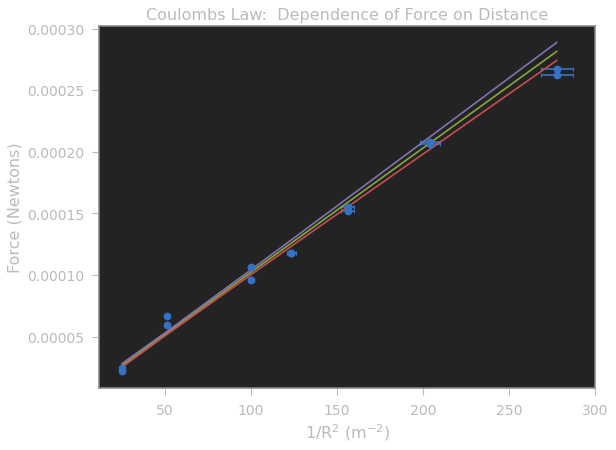

In [8]:
xi = 1.0/(df2['R'])**2
yi = df2['Force']

sigmaxi = xi*2.0*(df2['dR']/df2['R'])
sigmayi = df2['dForce']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction)
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi)
myodr = ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.cov_beta
perr = myoutput.sd_beta

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################
plt.xlabel('1/R$^2$ (m$^{-2})$')
plt.ylabel('Force (Newtons)')
plt.title('Coulombs Law:  Dependence of Force on Distance')
plt.show()

## Preliminary observations 

So, our first observation is that indeed, the plot seems roughly linear, as we expected!  This means that our guess for the form of the force law was probably correct!  

We know that the slope is supposed to be $k Q_1 Q_2$.  So, what are $Q_1$ and $Q_2$?  According to the same theory, they should be
equal to one another, and be related to the applied voltage, V, according to:

$Q = \frac{R_{sphere}}{k} V$

Substituting this into our experession for the slope, we get:

$slope = k  \left( \frac{R_{sphere}}{k} V \right) \left( \frac{R_{sphere}}{k}V \right) = \frac{R_{sphere}^2 V^2}{k}$

$k = \frac{R_{sphere}^2 V^2}{slope}$

We used $V = 6.00~kV = 6000~V$.
We are told that $R_{sphere} = 1.9~cm = 0.019~m$.

But, there are uncertainties in both of these numbers:

$dV = 10~Volts + (0.01)V = 10~Volts + 0.01(6000 V) = 70~Volts$.

$dR_{sphere} = 0.1~cm = 0.001~m$.

From basic error analysis, we get that $\frac{dk}{k} = 2 \frac{dR_{sphere}}{R_{sphere}} + 2\frac{dV}{V} + \frac{dslope}{slope}$

In [9]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[0]
# Let's choose +/- 3*sigma (99% confidence level) as the error in the slope.  Given that
# we are going to combine this error together with errors in the sphere radius and the
# sphere-to-sphere distance, which are clearly maximum possible error estimates, this is
# a reasonable choice.
dslope = 3*perr[0]

V = 6000
dV = 10 + 0.01*V
R_sphere = 0.019
dR_sphere = 0.001

k = R_sphere**2*V**2/slope
dk = k*(2*dR_sphere/R_sphere+2*dV/V+dslope/slope)

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1e9,dk/1e9))

Extracted value of k = (12.9 +/- 3.5) x 10^9 Nm^2/C^2


In [10]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['V',2*dV/V*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])

df4

,Source,Percentage Error
0,R_sphere,10.526316
1,V,2.333333
2,Slope,14.518278
3,Total,27.377927


# Analysis of Part II

Our first observation, as noted above, is that we see the expected linear dependence, as predicted by theory.

The extracted value of $k_e$ is $(12.9 \pm 3.5) \times 10^{9} Nm^2/C^2$.  This is slightly higher than the expected value of $k_e = 9 \times 10^{9} Nm^2/C^2$.


In [11]:
# Create a Pandas DataFrame with data for part 2 of the experiment:  understanding the relation of Force to Charge, at constant
# R

# The data elements are [Voltage in Volts, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors in the angle at this point

data2 = [[6000,97,0.5], [6000,100,0.5], [5000,75,0.5], [5000,78,0.5], 
         [4000,62,0.5], [4000,65,0.5], [3000,40,0.5], [3000,44,0.5], 
         [2000,25,0.5], [2000,23,0.5], [1000,10,0.5], [1000,11,0.5]]

# create dataframe
df3 = pd.DataFrame(data2, columns = ['V', 'Theta','dTheta'])
df3

,V,Theta,dTheta
0,6000,97,0.5
1,6000,100,0.5
2,5000,75,0.5
3,5000,78,0.5
4,4000,62,0.5
5,4000,65,0.5
6,3000,40,0.5
7,3000,44,0.5
8,2000,25,0.5
9,2000,23,0.5


The theory tells us that $F = k \frac{Q_1  Q_2}{R^2} = \frac{k Q^2}{R^2}$.

The theory also tells us that $Q = (\frac{R_{sphere}}{k})  V$
 
Thus, we have that $F = \frac{k (\frac{R_{sphere}}{k} V)^2}{R^2} = \frac{1}{k} (\frac{R_{sphere}}{R})^2 V^2$

So, if we plot $F$ vs. $V^2$, we should get a straight line.


In [12]:

df3['Force'] = df3['Theta']*calibration_factor
df3['dForce'] = df3['Force']*(dcalibration_factor/calibration_factor + 
                              df3['dTheta']/df3['Theta'])

df3['dV'] = 10.0 + 0.01*df3['V']

# It turns out, due to some numerical precision issues, that in order to get
# a successful fit we need to plot the voltage in kV, rather than Volts.
#
# If you are interested in the specifics of why that happens, please ask me about it!

#df3['kV'] = df3['V']/1000.0
#df3['dkV'] = df3['dV']/1000.0

df3

,V,Theta,dTheta,Force,dForce,dV
0,6000,97,0.5,0.000143,1.489698e-06,70.0
1,6000,100,0.5,0.000148,1.512957e-06,70.0
2,5000,75,0.5,0.000111,1.319131e-06,60.0
3,5000,78,0.5,0.000115,1.342390e-06,60.0
4,4000,62,0.5,0.000091,1.218342e-06,50.0
5,4000,65,0.5,0.000096,1.241601e-06,50.0
6,3000,40,0.5,0.000059,1.047775e-06,40.0
7,3000,44,0.5,0.000065,1.078787e-06,40.0
8,2000,25,0.5,0.000037,9.314793e-07,30.0
9,2000,23,0.5,0.000034,9.159732e-07,30.0


Beta: [ 2.31239887e+11 -3.47956607e+06]
Beta Std Error: [1.64107719e+10 8.14810452e+05]
Beta Covariance: [[ 9.54089089e+18 -3.79566202e+14]
 [-3.79566202e+14  2.35203669e+10]]
Residual Variance: 28.227283836589486
Inverse Condition #: 2.9706974590616014e-05
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (231239886848.604949951 +/- 16410771926.897964478) X + (-3479566.073010480 +/- 814810.452172649)


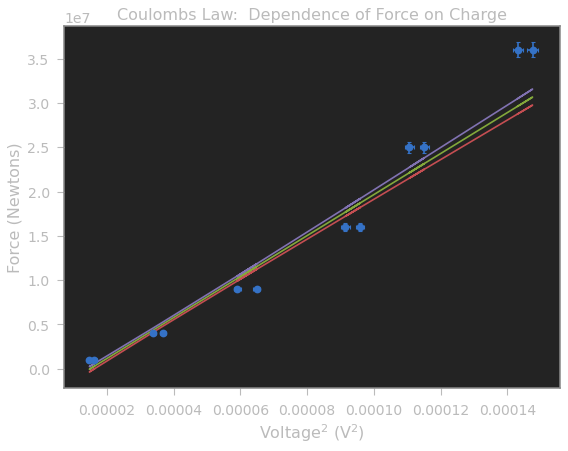

In [13]:
yi = (df3['V'])**2
xi = df3['Force']
sigmaxi = df3['dForce']
sigmayi = 2.0*yi*(df3['dV']/df3['V'])

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction)
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi)
myodr = ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.cov_beta
perr = myoutput.sd_beta

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Voltage$^2$ (V$^2$)')
plt.ylabel('Force (Newtons)')
plt.title('Coulombs Law:  Dependence of Force on Charge')
plt.show()

In [14]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[0]
dslope = 3*perr[0]

# We know that the slope is supposed to be:  k * (R/R_sphere)^2.
#
#  k = (R_sphere/R)^2*slope
#
# From basic error analysis, we get that (dk/k) = 2dR_sphere/R_sphere + 2dR/R + dslope/slope

R = 0.08
dR = 0.001

k = slope * R_sphere**2/R**2
dk = k*(2*dR/R+2*dR_sphere/R_sphere+dslope/slope)

# NOTE!!!!!  We divide here by 10^3 instead of 10^9 because of the choice above
# to plot in kV, instead of Volts ... there is a factor or 10^6 difference because we are
# plotting V^2.

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E9,dk/1E9))

Extracted value of k = (13.0 +/- 4.5) x 10^9 Nm^2/C^2


In [15]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['R',2*dR/R*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,R,2.500000
2,Slope,21.290581
3,Total,34.316897


# Analysis of Part III

Our first observation, is that we see somewhat of an expected linear dependence, as predicted by theory, but it is not as clear as in part II.

The extracted value of $k_e$ is $(13.0 \pm 4.5) \times 10^{9} Nm^2/C^2$.  This is in agreement with the expected vale of $k_e = 9 \times 10^{9} Nm^2/C^2$.  

It is also very close to the value extracted in part II.  This leads us to think that perhaps there is some common systematic uncertainty that results in a shift away from the accepted central value in both parts of the experiment.

Given the rather large uncertainty in the sphere radius used in this analysis, there is reason to think that this might be the most like culprit.

# Extra Analysis: What Coulomb Actually Did

So, what we did above is interesting, but actually does not really answer the question that we set out to answer, which is:
What is the form of the force law?  What we should actually be doing is assuming that the Force law follows the following form:

$F = k \frac{Q_1^\alpha Q_2^\alpha}{R^\beta}$

and then determining the values of $\alpha$ and $\beta$ that best describe the data.  We expect $\alpha=1$ and $\beta=2$.  But is that what the data tells us?



Beta: [1.28599918e-06 1.90154419e+00]
Beta Std Error: [2.45518511e-07 8.15925519e-02]
Beta Covariance: [[ 4.09754583e-15 -1.34797954e-09]
 [-1.34797954e-09  4.52539369e-04]]
Residual Variance: 14.711083650239813
Inverse Condition #: 4.264980878637468e-07
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.000001286 +/- 0.000000246)*X^(1.901544191 +/- 0.081592552)


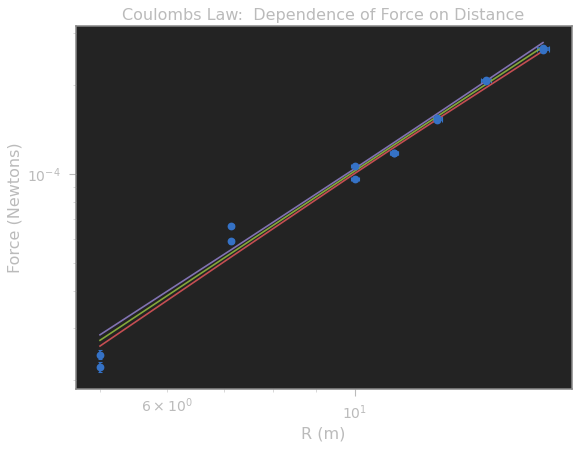

In [16]:
# Part II Analysis
#
# Plot F vs. 1/R, and then determine beta (expect beta = 2)
#

xi = 1.0/df2['R']
yi = df2['Force']

sigmaxi = xi*(df2['dR']/df2['R'])
sigmayi = df2['dForce']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Non-linear function y = C*x^(beta)'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x**B[1]

nonlinear = Model(fitfunction)
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi)
myodr = ODR(mydata, nonlinear, beta0=[1., 2.])
myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.cov_beta
perr = myoutput.sd_beta

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f)*X^(%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)



#########################
plt.xlabel('R (m)')
plt.ylabel('Force (Newtons)')
plt.xscale("log")
plt.yscale("log")
plt.title('Coulombs Law:  Dependence of Force on Distance')
plt.show()


In [17]:
# extract the values of C and beta from the fit
# 
beta = popt[1]
dbeta = perr[1]

print('Extracted value of beta = (%0.2f +/- %0.2f)' % (beta,dbeta))

C = popt[0]
dC = 3*perr[0]

#
# Now, let us see if we can calculate what k is, based on the parameters from the previous graph
#
# Following the development above, we can show that C = kQ^2 ... k = C/Q^2
# 
# k = C/(R_sV/k)^2 ... k = C*k^2/(R_s^2V^2) ... k = R_s^2V^2/C

V = 6000
dV = 10 + 0.01*V
R_sphere = 0.019
dR_sphere = 0.001

k = R_sphere**2*V**2/C
dk = k*(2*dR_sphere/R_sphere+2*dV/V+dC/C)

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E9,dk/1E9))

Extracted value of beta = (1.90 +/- 0.08)
Extracted value of k = (10.1 +/- 7.1) x 10^9 Nm^2/C^2


In [18]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['R',2*dR/R*100],['C',dC/C*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,R,2.500000
2,C,57.274962
3,Total,70.134611


# Extra Analysis: Part III

Now that we have established that $\beta=2$ is a good choice, let's investigate the charge
dependence according to:

$F = k \frac{Q_1^\alpha Q_2^\alpha}{R^2} = k \frac{Q^{2\alpha}}{R^2} = \left( \frac{R_{sphere}^{2\alpha}}{R^2 k^{2\alpha-1}} \right) V^{2\alpha} = C^\prime V^{2\alpha}$

and then determining the value of $\alpha$ that bests describe the data.  We expect $\alpha=1$.  But is that what the data tells us?



Beta: [2.62742776e-09 6.28227821e-01]
Beta Std Error: [7.88633375e-10 1.80221089e-02]
Beta Covariance: [[ 1.33090324e-19 -3.03790556e-12]
 [-3.03790556e-12  6.95036153e-05]]
Residual Variance: 4.673086533532339
Inverse Condition #: 2.1041775548535266e-09
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.000000003 +/- 0.000000001)*X^2(0.628227821 +/- 0.018022109)


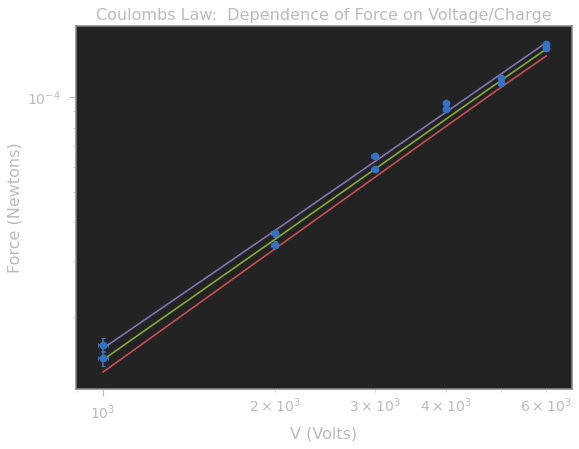

In [19]:
# Part III Analysis
#
# Plot F vs. Q, and then fit with a non-linear function F = C*Q^alpha to determine alpha.
#

xi = df3['V']
yi = df3['Force']

sigmaxi = df3['dV']
sigmayi = df3['dForce']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Non-linear function y = C*x^(2*alpha)'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x**(2.0*B[1])

nonlinear = Model(fitfunction)
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi)
myodr = ODR(mydata, nonlinear, beta0=[1., 1.])
myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.cov_beta
perr = myoutput.sd_beta

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f)*X^2(%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)



#########################
plt.xlabel('V (Volts)')
plt.ylabel('Force (Newtons)')
plt.yscale("log")
plt.xscale("log")
plt.title('Coulombs Law:  Dependence of Force on Voltage/Charge')
plt.show()


In [20]:
# extract the values of C' and alpha from the fit
# 
alpha = popt[1]
dalpha = perr[1]

print('Extracted value of alpha = (%0.2f +/- %0.2f)' % (alpha,dalpha))
print('The expected value is alpha=1, so we are a long way off from that ... why?')

Extracted value of alpha = (0.63 +/- 0.02)
The expected value is alpha=1, so we are a long way off from that ... why?
